In [20]:
from collections import defaultdict
from nltk.wsd import lesk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display



In [21]:
def load_data(file_path):
    """
    Loads sentences from a file and returns them as a list.

    Args:
        file_path (str): Path to the file containing sentences.

    Returns:
        list: A list of sentences.
    """
    sentences = []

    try:
        with open(file_path, 'r') as file:
            for line in file:
                sentence = line.strip()
                sentences.append(sentence)
    except FileNotFoundError:
        print("File not found.")
    
    return sentences

sentences = load_data('../lab3/res/sentences.txt')


In [22]:
verb = 'play'

In [23]:
def get_left_and_right(sentences, verb):
    """
    Extracts left and right dependencies of a specified verb in sentences.

    Args:
        sentences (list): List of sentences to analyze.
        verb (str): The verb for which dependencies are extracted.

    Returns:
        Two lists - left dependencies and right dependencies.
    """
    nlp = spacy.load('en_core_web_sm')
    left = []
    right = []
    for sentence in sentences:
        doc = nlp(sentence)
        for token in doc:
            if token.lemma_ == verb:
                for child in token.lefts:
                    disamb_left = (lesk(sentence, child.lemma_))
                    if disamb_left is not None:
                        left.append(disamb_left)
                for child in token.rights:
                    disamb_right = (lesk(sentence, child.text))
                    if disamb_right is not None:
                        right.append(disamb_right)

    return left, right


left,right  = get_left_and_right(sentences, verb)


In [24]:
def get_supersenses(synsets):
    """
    Extracts supersenses (lexical names) from a list of synsets.

    Args:
        synsets (list): List of synsets to extract supersenses from.

    Returns:
        list: A list of supersenses (lexical names) corresponding to the synsets.
    """
    supersenses = []
    for synset in synsets:
        if synset is not None:
            supersense = synset.lexname()
            supersenses.append(supersense)
    return supersenses


l_sups = get_supersenses(left)
r_sups = get_supersenses(right)

In [25]:
def create_connections(left, right):
    """
    Creates connections between left and right dependencies.

    Args:
        left (list): List of left dependencies.
        right (list): List of right dependencies.

    Returns:
        tuple: A tuple containing two defaultdicts - connected left dependencies and connected right dependencies.
    """
    connected_left = defaultdict(set)
    connected_right = defaultdict(set)

    for left_dep, right_dep in zip(left, right):
        connected_left[left_dep].add(right_dep)
        connected_right[right_dep].add(left_dep)

    return connected_left, connected_right




connected_left, connected_right = create_connections(l_sups, r_sups)

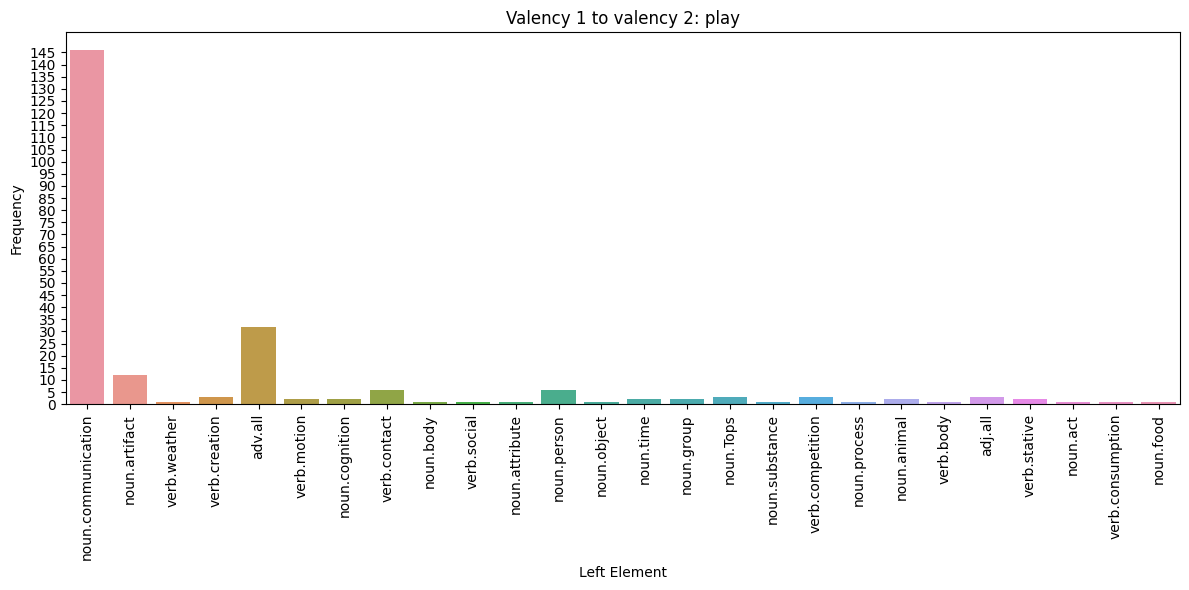

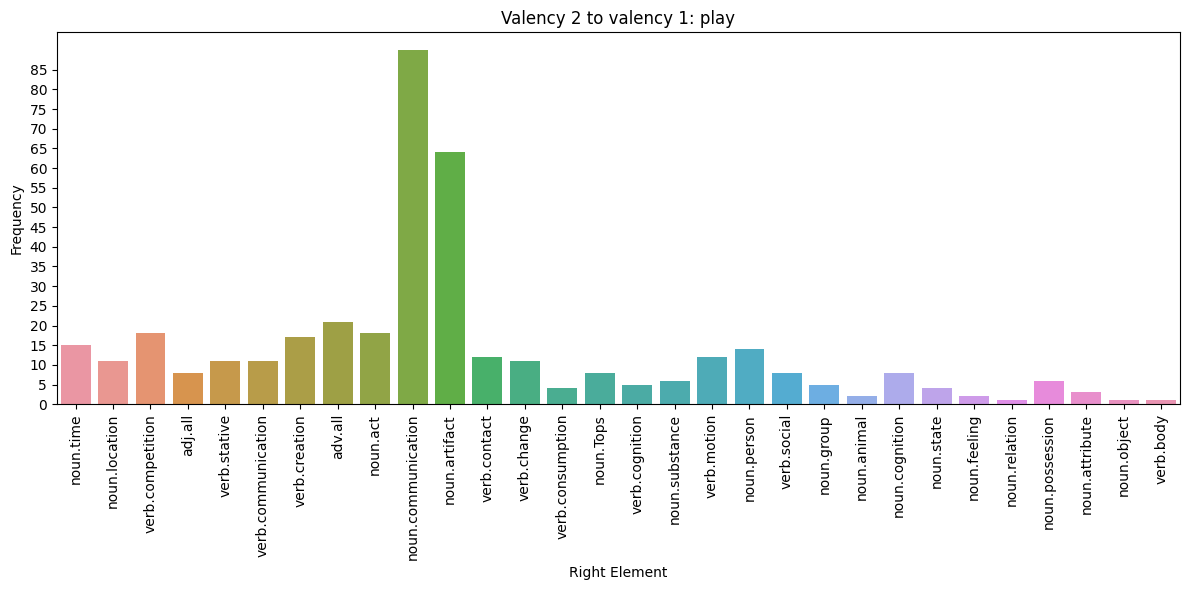

In [26]:

def plot_freqs(verb, l_sups, r_sups, connected_left, connected_right):
    """
    Plots the results of the connections between left and right dependencies using seaborn.

    Args:
        verb (str): The verb being analyzed.
        l_sups (list): List of left supersenses.
        r_sups (list): List of right supersenses.
        connected_left (defaultdict): Dictionary of connected left dependencies.
        connected_right (defaultdict): Dictionary of connected right dependencies.

    Returns:
        None
    """
    left_freqs = []
    right_freqs = []

    for item in connected_left:
        freq = len([i for i in range(len(l_sups)) if l_sups[i] == item])
        left_freqs.append(freq)

    for item in connected_right:
        freq = len([i for i in range(len(r_sups)) if r_sups[i] == item])
        right_freqs.append(freq)

    fig1, axs1 = plt.subplots(figsize=(12, 6))  # Create a new figure for the first plot

    sns.barplot(x=list(connected_left.keys()), y=left_freqs, ax=axs1)
    axs1.set_title(f"Valency 1 to valency 2: {verb}")
    axs1.set_xlabel("Left Element")
    axs1.set_ylabel("Frequency")
    axs1.tick_params(axis='x', rotation=90)  # Increase the rotation of the x-axis labels
    axs1.set_yticks(np.arange(0, max(left_freqs), 5))  # Set y-axis granularity

    plt.tight_layout()
    plt.show()  # Display the first plot

    # Plotting the second bar plot
    fig2, axs2 = plt.subplots(figsize=(12, 6))  # Create a new figure for the second plot

    sns.barplot(x=list(connected_right.keys()), y=right_freqs, ax=axs2)
    axs2.set_title(f"Valency 2 to valency 1: {verb}")
    axs2.set_xlabel("Right Element")
    axs2.set_ylabel("Frequency")
    axs2.tick_params(axis='x', rotation=90)  # Increase the rotation of the x-axis labels
    axs2.set_yticks(np.arange(0, max(right_freqs), 5))  # Set y-axis granularity

    plt.tight_layout()
    plt.show()



plot_freqs(verb, l_sups, r_sups, connected_left, connected_right)


In [27]:
def show_clusters(cluster_left, cluster_right, connected_items_left, connected_items_right):
    # Prepare data for the first table
    data1 = []
    for item in connected_items_left:
        freq = len([i for i in range(len(cluster_left)) if cluster_left[i] == item])
        data1.append([item, str(connected_items_left[item]), freq])
    df1 = pd.DataFrame(data1, columns=['Left Element', 'Right Element', 'Frequency'])

    # Style the first DataFrame and center the text
    styled_df1 = df1.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'yellow'), ('color', 'black')]},
        {'selector': 'td', 'props': [('color', 'white')]},
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]).set_caption('Valency 1 to valency 2: Play')
    display(styled_df1)

    # Prepare data for the second table
    data2 = []
    for item in connected_items_right:
        freq = len([i for i in range(len(cluster_right)) if cluster_right[i] == item])
        data2.append([str(connected_items_right[item]), item, freq])
    df2 = pd.DataFrame(data2, columns=['Left Element', 'Right Element', 'Frequency'])

    # Style the second DataFrame and center the text
    styled_df2 = df2.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'yellow'), ('color', 'black')]},
        {'selector': 'td', 'props': [('color', 'white')]},
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]).set_caption('Valency 2 to valency 1: Play')
    display(styled_df2)

show_clusters(l_sups,r_sups,connected_left, connected_right)


,Left Element,Right Element,Frequency
0,noun.communication,"{'noun.communication', 'verb.body', 'noun.artifact', 'verb.change', 'verb.motion', 'noun.cognition', 'noun.location', 'adv.all', 'noun.relation', 'verb.competition', 'verb.communication', 'noun.animal', 'verb.contact', 'noun.act', 'noun.person', 'noun.Tops', 'noun.time', 'verb.social', 'verb.cognition', 'adj.all', 'noun.substance', 'verb.stative', 'noun.state', 'verb.creation', 'noun.attribute'}",146
1,noun.artifact,"{'noun.communication', 'noun.person', 'noun.feeling', 'noun.artifact', 'noun.group', 'noun.object', 'noun.act', 'adj.all', 'verb.stative', 'verb.communication', 'verb.creation'}",12
2,verb.weather,{'noun.act'},1
3,verb.creation,"{'noun.communication', 'noun.artifact', 'verb.motion'}",3
4,adv.all,"{'noun.communication', 'noun.person', 'verb.consumption', 'adv.all', 'noun.artifact', 'verb.change', 'noun.time', 'verb.contact', 'verb.competition', 'noun.cognition', 'adj.all', 'noun.location', 'verb.stative', 'verb.creation'}",32
5,verb.motion,"{'noun.artifact', 'noun.communication'}",2
6,noun.cognition,{'noun.communication'},2
7,verb.contact,"{'noun.communication', 'verb.change', 'verb.motion', 'verb.cognition', 'verb.communication', 'verb.creation'}",6
8,noun.body,{'noun.communication'},1
9,verb.social,{'verb.competition'},1


,Left Element,Right Element,Frequency
0,"{'noun.communication', 'noun.person', 'adv.all', 'verb.competition'}",noun.time,15
1,"{'noun.communication', 'adv.all'}",noun.location,11
2,"{'noun.communication', 'noun.person', 'adv.all', 'verb.social', 'adj.all', 'noun.substance', 'noun.animal'}",verb.competition,18
3,"{'noun.communication', 'noun.person', 'adv.all', 'noun.artifact', 'noun.animal'}",adj.all,8
4,"{'noun.artifact', 'noun.communication', 'adv.all'}",verb.stative,11
5,"{'noun.communication', 'noun.artifact', 'noun.Tops', 'verb.contact'}",verb.communication,11
6,"{'noun.communication', 'noun.artifact', 'verb.contact', 'adv.all'}",verb.creation,17
7,"{'noun.communication', 'noun.food', 'adv.all'}",adv.all,21
8,"{'noun.communication', 'noun.artifact', 'verb.weather'}",noun.act,18
9,"{'noun.communication', 'noun.person', 'adv.all', 'noun.process', 'noun.artifact', 'noun.Tops', 'noun.time', 'verb.motion', 'noun.group', 'verb.contact', 'noun.body', 'verb.competition', 'noun.cognition', 'noun.attribute', 'verb.creation'}",noun.communication,90
